In [7]:
# Step 1: Install all required libraries FIRST
!pip install tensorflow tensorflow_datasets matplotlib scikit-learn seaborn
print("All libraries installed successfully!")

All libraries installed successfully!


In [1]:
# Step 2: Now import all libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("All libraries imported successfully!")
print("TensorFlow version:", tf.__version__)

All libraries imported successfully!
TensorFlow version: 2.19.0


In [2]:
# Step 3: Load and explore the dataset
print("Loading tf_flowers dataset...")

try:
    # Load the dataset
    (train_ds, train_labels), (test_ds, test_labels) = tfds.load(
        "tf_flowers",
        split=["train[:70%]", "train[:30%]"],  # 70% train, 30% test
        batch_size=-1,  # Load all data at once
        as_supervised=True,  # Return (image, label) tuples
    )
    
    print(" Dataset loaded successfully!")
    print(f"Training images: {len(train_ds)}")
    print(f"Test images: {len(test_ds)}")
    print(f"Image shape: {train_ds[0].shape}")
    print(f"Sample label: {train_labels[0]}")
    print(f"Unique labels in training: {np.unique(train_labels)}")
    
except Exception as e:
    print(f" Error loading dataset: {e}")

Loading tf_flowers dataset...



 Dataset loaded successfully!
Training images: 2569
Test images: 1101
Image shape: (442, 1024, 3)
Sample label: 2
Unique labels in training: [0 1 2 3 4]


Displaying sample images from the dataset...


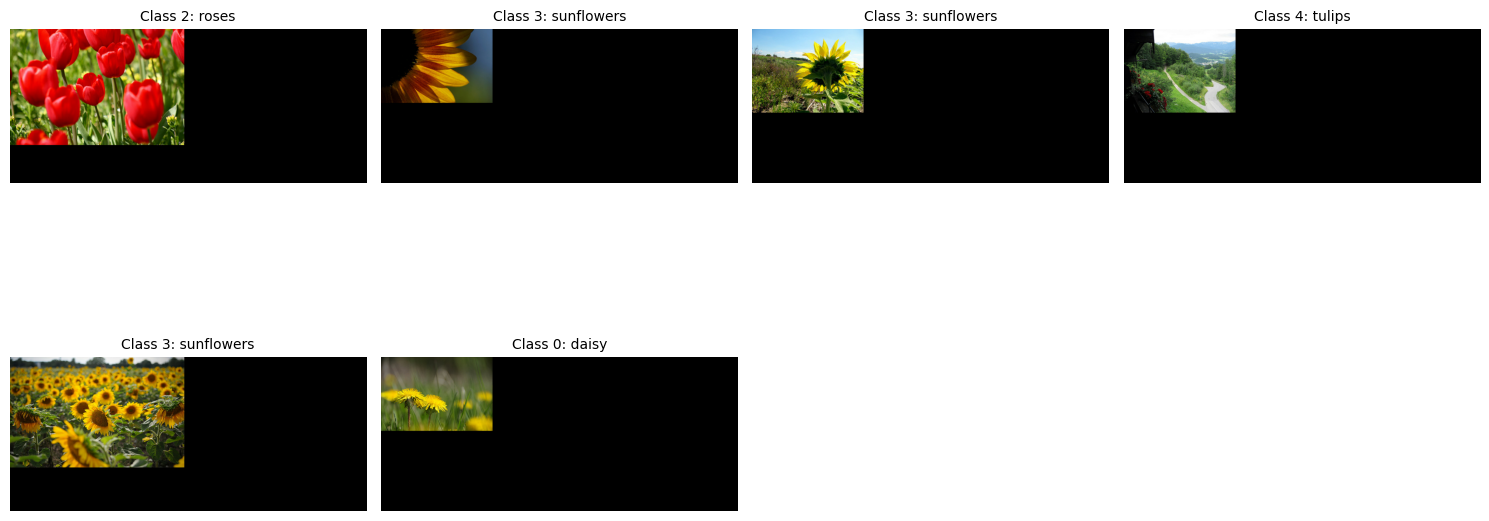

Total classes: 5


In [3]:
# Step 4: Show sample images
print("Displaying sample images from the dataset...")

# Flower class names (based on tf_flowers documentation)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

plt.figure(figsize=(15, 10))
for i in range(6):  # Show 6 samples
    plt.subplot(3, 4, i+1)
    plt.imshow(train_ds[i].numpy().astype('uint8'))
    label_idx = train_labels[i]
    plt.title(f"Class {label_idx}: {class_names[label_idx]}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Total classes: {len(class_names)}")

In [4]:
# Step 5: Preprocess the data
print("Preprocessing images and labels...")

# Resize images to 150x150 (smaller than VGG16's 224x224 for faster training)
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

print(f"Original image count - Train: {len(train_ds)}, Test: {len(test_ds)}")
print(f"Image shape after resizing: {train_ds[0].shape}")

# Convert labels to categorical (one-hot encoding)
# Why one-hot? Because we have 5 mutually exclusive classes
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

print(f"Labels shape after one-hot encoding: {train_labels.shape}")
print(f"Sample label conversion:")
print(f"  Original: {np.argmax(train_labels[0])} -> One-hot: {train_labels[0]}")

Preprocessing images and labels...
Original image count - Train: 2569, Test: 1101
Image shape after resizing: (150, 150, 3)
Labels shape after one-hot encoding: (2569, 5)
Sample label conversion:
  Original: 2 -> One-hot: [0. 0. 1. 0. 0.]


In [5]:
# Step 6: Load pre-trained VGG16 model
print("Loading pre-trained VGG16 model...")

# Load VGG16 without the top classification layers
base_model = VGG16(
    weights="imagenet",        # Use weights pre-trained on ImageNet
    include_top=False,         # Exclude the final 1000-class classifier
    input_shape=(150, 150, 3)  # Our resized image dimensions
)

# FREEZE THE BASE MODEL - This is crucial for transfer learning!
# Why freeze? We want to preserve the feature extraction capabilities
# learned from ImageNet and only train our custom classifier
base_model.trainable = False

print(" Base model loaded and frozen!")
print(f"Number of layers in VGG16: {len(base_model.layers)}")
print(f"Trainable parameters in base model: {sum([layer.trainable for layer in base_model.layers])}")

Loading pre-trained VGG16 model...
 Base model loaded and frozen!
Number of layers in VGG16: 19
Trainable parameters in base model: 0


In [6]:
# Step 7: Build our custom classifier on top of VGG16
print("Building custom classifier...")

model = models.Sequential([
    # 1. Pre-trained VGG16 as feature extractor
    base_model,
    
    # 2. Flatten 2D feature maps to 1D vector
    # Why flatten? Dense layers need 1D input, but conv layers output 2D feature maps
    layers.Flatten(),
    
    # 3. First dense layer with dropout
    layers.Dense(512, activation='relu'),  # 512 neurons with ReLU activation
    layers.Dropout(0.5),  # Drop 50% of neurons randomly to prevent overfitting
    
    # 4. Second dense layer
    layers.Dense(256, activation='relu'),  # 256 neurons
    layers.Dropout(0.3),  # Drop 30% of neurons
    
    # 5. Final output layer
    # 5 neurons = 5 flower classes, softmax for probability distribution
    layers.Dense(5, activation='softmax')
])

print(" Model architecture built!")
model.summary()

Building custom classifier...
 Model architecture built!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,042,117 (72.64 MB)

 Trainable params: 4,327,429 (16.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# Step 8: Compile the model
print("Compiling the model...")

model.compile(
    optimizer='adam',                    # Adaptive learning rate optimizer
    loss='categorical_crossentropy',     # Appropriate for multi-class classification
    metrics=['accuracy']                 # We care about classification accuracy
)

print(" Model compiled successfully!")

Compiling the model...
 Model compiled successfully!


In [8]:
# Step 9: Set up early stopping
print("Setting up training callbacks...")

early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Watch validation accuracy
    patience=5,               # Stop after 5 epochs without improvement
    restore_best_weights=True, # Restore weights from best epoch
    verbose=1
)

print(" Early stopping configured!")

Setting up training callbacks...
 Early stopping configured!


In [9]:
# Step 10: Preprocess images for VGG16
print("Preprocessing images for VGG16...")

# VGG16 expects specific preprocessing (BGR channel ordering, etc.)
train_ds_processed = preprocess_input(train_ds)
test_ds_processed = preprocess_input(test_ds)

print(" Images preprocessed for VGG16!")

Preprocessing images for VGG16...
 Images preprocessed for VGG16!


In [11]:
# Step 11: Train the model
print("Starting model training...")

history = model.fit(
    train_ds_processed,      # Preprocessed training images
    train_labels,            # One-hot encoded labels
    # epochs=30,               # Maximum number of epochs
    epochs=1,               # Maximum number of epochs
    batch_size=32,           # 32 images per batch
    validation_split=0.2,    # Use 20% of training data for validation
    callbacks=[early_stopping],  # Stop early if no improvement
    verbose=1                # Show progress bars
)

print(" Training completed!")

Starting model training...
65/65 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.5298 - loss: 3.5781 - val_accuracy: 0.6362 - val_loss: 1.2509
Restoring model weights from the end of the best epoch: 1.
 Training completed!


In [12]:
# Step 12: Evaluate the model
print("Evaluating model on test data...")

# Evaluate on unseen test data
test_loss, test_accuracy = model.evaluate(test_ds_processed, test_labels, verbose=0)
print(f" Test Loss: {test_loss:.4f}")
print(f" Test Accuracy: {test_accuracy:.4f}")

# Make predictions
print("Making predictions...")
predictions = model.predict(test_ds_processed)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Show sample predictions
print("\n Sample predictions:")
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
correct_count = 0
for i in range(15):
    pred_idx = predicted_classes[i]
    true_idx = true_classes[i]
    is_correct = pred_idx == true_idx
    if is_correct:
        correct_count += 1
    
    status = "true" if is_correct else "false"
    print(f"{status} Predicted: {class_names[pred_idx]:12} | Actual: {class_names[true_idx]:12}")

print(f"\nSample accuracy: {correct_count}/15 = {correct_count/15:.2%}")

Evaluating model on test data...
 Test Loss: 0.6808
 Test Accuracy: 0.7657
Making predictions...
35/35 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step

 Sample predictions:
true Predicted: roses        | Actual: roses       
false Predicted: tulips       | Actual: sunflowers  
true Predicted: sunflowers   | Actual: sunflowers  
false Predicted: roses        | Actual: tulips      
true Predicted: sunflowers   | Actual: sunflowers  
true Predicted: daisy        | Actual: daisy       
false Predicted: dandelion    | Actual: daisy       
true Predicted: daisy        | Actual: daisy       
false Predicted: tulips       | Actual: daisy       
false Predicted: roses        | Actual: dandelion   
false Predicted: dandelion    | Actual: sunflowers  
true Predicted: roses        | Actual: roses       
true Predicted: tulips       | Actual: tulips      
true Predicted: dandelion    | Actual: dandelion   
true Predicted: roses        | Actual: roses       

Sample accuracy: 9/15 = 60.00%


Plotting training history...


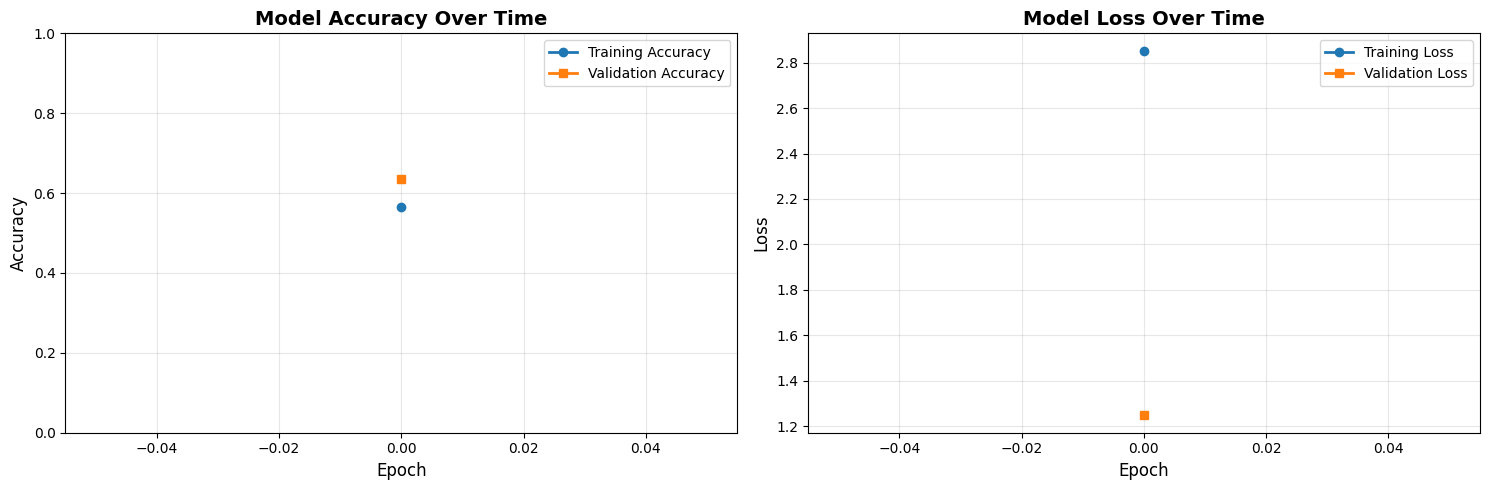

 Training stopped after 1 epochs
 Final Training Accuracy: 0.5655
 Final Validation Accuracy: 0.6362


In [13]:
# Step 13: Plot training history
print("Plotting training history...")

plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
plt.title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
plt.title('Model Loss Over Time', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_epoch = len(history.history['accuracy'])
print(f" Training stopped after {final_epoch} epochs")
print(f" Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f" Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Generating detailed performance report...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       daisy     0.8735    0.7456    0.8045       287
   dandelion     0.6230    0.8128    0.7053       187
       roses     0.7722    0.7689    0.7705       238
  sunflowers     0.8418    0.6963    0.7622       191
      tulips     0.7419    0.8131    0.7759       198

    accuracy                         0.7657      1101
   macro avg     0.7705    0.7674    0.7637      1101
weighted avg     0.7799    0.7657    0.7678      1101



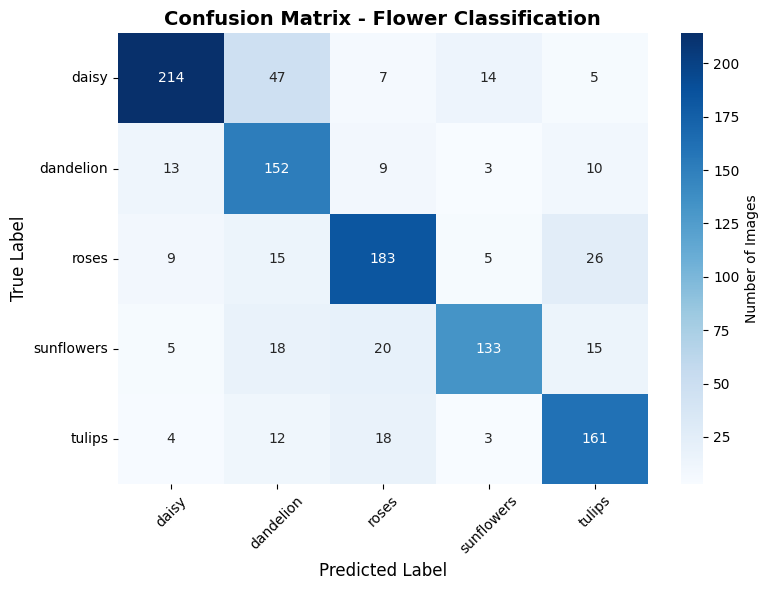


 OVERALL TEST ACCURACY: 0.7657 (76.57%)


In [14]:
# Step 14: Detailed performance analysis
print("Generating detailed performance report...")

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(true_classes, predicted_classes, 
                          target_names=class_names, digits=4))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Images'})
plt.title('Confusion Matrix - Flower Classification', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate overall accuracy
overall_accuracy = np.mean(predicted_classes == true_classes)
print(f"\n OVERALL TEST ACCURACY: {overall_accuracy:.4f} ({overall_accuracy:.2%})")